In [2]:
import pandas
import contextily
import geopandas
import math 
import shapely
import numpy
from shapely import geometry
import geopy
import xarray

import geodesy


ModuleNotFoundError: No module named 'xarray'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Area of germany
min_latitude = 47
min_longitude = 5.5
max_latitude = 55
max_longitude = 15

In [24]:
grid = geodesy.Grid(min_latitude, min_longitude, max_latitude, max_longitude, 100000, 3)

In [ ]:
def calc_SPL_from_R(splE, r, h):
    R = numpy.sqrt(r**2 + h**2)
    return splE + 20*numpy.log10(1/R)

def calc_R_from_SPL(splE, splI):
    return 10.**((splE-splI) / 20.)

today = pandas.to_datetime('2024-01-01')

In [55]:

dynamic_grid = geodesy.DynamicGrid(min_latitude, min_longitude, max_latitude, max_longitude, 100)
#dynamic_grid.index_of(latitude, longitude)

#dynamic_grid.cell_at(index_of_center[0], index_of_center[1])['geometry'].exterior.coords.xy
#window = (dynamic_grid.window(47.854444, 12.186111, 2000))


722088.8041336566


In [ ]:
power_plants = xarray.open_dataset('WEA.nc').to_dataframe().set_index(['lat', 'lon']).reset_index()


power_plants['sound_emission'] = power_plants['max_sound_power_level'] - 11.
power_plants['date_online'] = pandas.to_datetime(power_plants['date_online'], format='%Y-%m-%d')
power_plants['age'] = ((today - power_plants['date_online']) / numpy.timedelta64(1, 'D')).astype(int)
power_plants['age_years'] = numpy.round(df['age']/365, 1)
power_plants['r_max'] = power_plants.sound_emission.apply(lambda _: calc_R_from_SPL(_, 30.))
geometry = [geometry.Point(x,y) for x, y in zip(power_plants['lon'], power_plants['lat'])]
power_plants = geopandas.GeoDataFrame(power_plants, geometry=geometry, crs="epsg:4326")
power_plants = power_plants[power_plants.lat<=max_latitude]
power_plants = power_plants.sort_values(["lat", "lon"])

 

In [18]:
widest_cell = geopandas.GeoDataFrame([dynamic_grid.cell_at(dynamic_grid.I, 0)])\
.set_crs(epsg=4326)
widest_cell

,geometry,i,j
0,"POLYGON ((15 47, 15.00132 47, 15.00132 47.0009...",7221,0


In [20]:
number_of_samples = 1000
sample = numpy.random.random_sample((number_of_samples,2))
scale = numpy.array([
        (max_latitude - min_latitude),
        (max_longitude - min_longitude) 
            ])
offset = numpy.array([min_latitude, min_longitude])
coordinates = sample * scale + offset
points = geopandas.GeoDataFrame({"Geometry": geometry.Point(coordinate[1], coordinate[0])} for coordinate in coordinates).set_geometry("Geometry").set_crs(4326)

In [21]:
axes =  window.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.5, edgecolor="k")

contextily.add_basemap(axes,crs="epsg:3857")

NameError: name 'window' is not defined

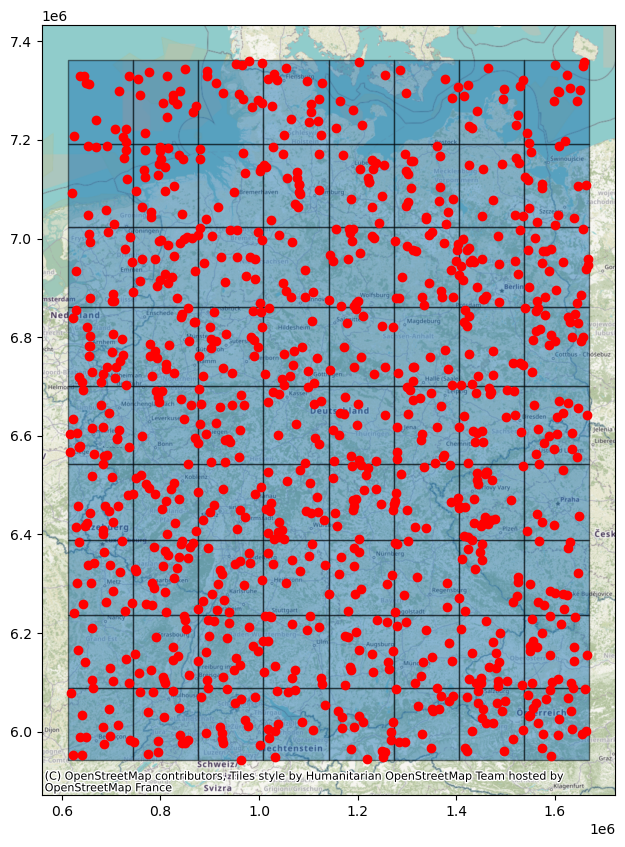

In [25]:
axes =  grid.geodataframe.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
points.to_crs(epsg=3857).plot(ax=axes, color="r")
contextily.add_basemap(axes,crs="epsg:3857")

In [13]:
%%time


with open("dump.csv", 'wt') as file:

    for (_,point) in points.iterrows():
        (longitude, latitude) = (point.Geometry.x, point.Geometry.y)
        for ((i,j), row) in (dynamic_grid.window(latitude, longitude, 1000)).iterrows():
            file.write(f"{i},{j},{row.distance}\n")

CPU times: user 1min 55s, sys: 1.09 s, total: 1min 56s
Wall time: 1min 57s


In [26]:
frame = pandas.read_csv('dump.csv', names=["i", "j", "distance"])

In [28]:
aggregated = frame.groupby(["i", "j"]).sum().sort_values("distance").reset_index()

In [43]:
geodataframe = geopandas.GeoDataFrame((_ for _ in aggregated.apply(lambda _ : dynamic_grid.cell_at(_.i, _.j), axis=1)))
.set_index(["i", "j"]).set_crs(epsg=4326)

In [44]:
geodataframe.to_file("grid.gpkg", driver="GPKG")

In [56]:
#test_index = dynamic_grid.index_of(points.loc[4, "Geometry"].y, points.loc[4, "Geometry"].x)
test_window = dynamic_grid.window(points.loc[4, "Geometry"].y, points.loc[4, "Geometry"].x, 1000)

geometry    distance
i    j                                                                  
7067 3272  POLYGON ((14.7974 49.94112, 14.79871 49.94112,...  994.532794
     3273  POLYGON ((14.7974 49.94202, 14.79871 49.94202,...  974.894022
     3274  POLYGON ((14.7974 49.94292, 14.79871 49.94292,...  965.263332
     3275  POLYGON ((14.7974 49.94382, 14.79871 49.94382,...  965.940125
     3276  POLYGON ((14.7974 49.94472, 14.79871 49.94472,...  976.902984
...                                                      ...         ...
7087 3274  POLYGON ((14.82371 49.94292, 14.82502 49.94292...  925.404471
     3275  POLYGON ((14.82371 49.94382, 14.82502 49.94382...  926.111150
     3276  POLYGON ((14.82371 49.94472, 14.82502 49.94472...  937.540601
     3277  POLYGON ((14.82371 49.94562, 14.82502 49.94562...  959.309644
     3278  POLYGON ((14.82371 49.94652, 14.82502 49.94652...  990.736955

[335 rows x 2 columns]

In [209]:
def get_bounding_box(window):
    (long_max, lat_max) = tuple(numpy.concat(((test_window['geometry'].reset_index()['geometry']
                               .apply(lambda _ : (numpy.array(_.exterior.coords.xy)).max(axis=1).reshape(1, 2)).values))).max(axis=0))
    (long_min, lat_min) = tuple(numpy.concat(((test_window['geometry'].reset_index()['geometry']
                               .apply(lambda _ : (numpy.array(_.exterior.coords.xy)).min(axis=1).reshape(1, 2)).values))).min(axis=0))
    print(f"({long_min}, {lat_min}, {long_max}, {lat_max})")
    return geopandas.GeoDataFrame([
    {"geometry":geometry.Polygon([
    (long_min,lat_min ), 
    (long_max, lat_min ),
        (long_max, lat_max ),
        (long_min, lat_max )
                                        
                                        ])}]).set_crs(epsg=4326)
bounding_box = get_bounding_box(test_window)
bounding_box.geometry

(14.79739648248165, 49.93483146067416, 14.825024234870517, 49.95280898876404)


0    POLYGON ((14.7974 49.93483, 14.82502 49.93483,...
Name: geometry, dtype: geometry

<Axes: >

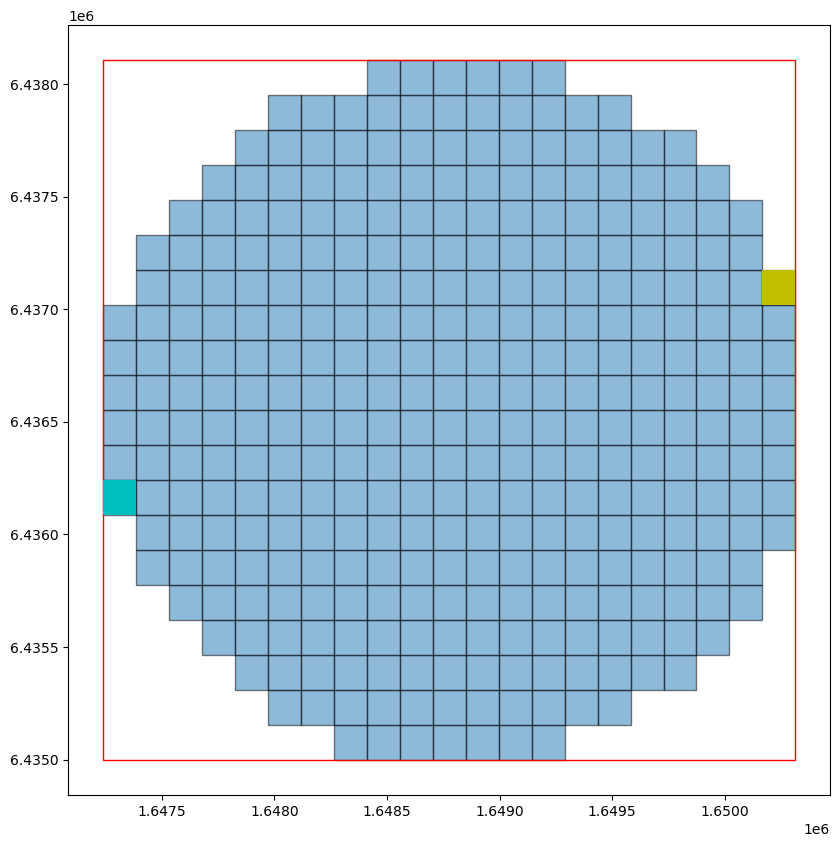

In [197]:
axes =  test_window.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
bounding_box.to_crs(epsg=3857).plot(ax=axes, edgecolor="r", facecolor="none")
test_window.loc[[bottom_left]].to_crs(epsg=3857).plot(ax=axes, color="c")
test_window.loc[[top_right]].to_crs(epsg=3857).plot(ax=axes, color="y")
#contextily.add_basemap(axes,crs="epsg:3857")

In [191]:
test_window['geometry'].bounds.min()

minx    14.797396
miny    49.934831
maxx    14.798712
maxy    49.935730
dtype: float64

In [226]:
geopandas.read_file("grid.gpkg", bbox=(14, 49, 14.82502423487051, 50))

,i,j,geometry


In [90]:
bounding_box

(14.79739648248165, 49.941123595505616, 14.823708627613904, 49.946516853932586)